# Estimation des hyperparamètres - EM - VBEM

Dans ce notebook, on s'intéresse à un modèle simple
$$y = Ax + b$$
où $b$ est une bruit gaussien centré de matrice de covariance $\sigma_b^2 I$, et $x$ un signal à reconstruire, suivant une loi normale centrée de matrice de covariance $I / \tau$. Le paramètre $\tau$ sera également estimé.


In [33]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

In [34]:
def generate_data(A, sigma_n, alpha, beta):
    
    tau = rand.gamma(alpha, 1/beta)
    
    x = rand.multivariate_normal(np.zeros([A.shape[1]]), np.eye(A.shape[1]) / tau);
    b = rand.multivariate_normal(np.zeros([A.shape[0]]), np.eye(A.shape[0]) * sigma_n);
    y = A @ x + b
    
    return y, x, tau

In [79]:
def sample_tau(x, y, alpha, beta):
    
    alpha2 = alpha + x.shape[0] / 2
    beta2 = beta + np.sum(x**2) / 2

    tau = rand.gamma(alpha2, 1/beta2)
    
    return tau


def sample_x(y, tau, A, sigma_n):
    
    Reap = np.linalg.inv(A.T @ A / sigma_n + tau * np.eye(A.shape[1]))
    Xeap = Reap @ A.T @ y / sigma_n
    
    x = rand.multivariate_normal(Xeap, Reap);
    
    return x

def gibbs(y, A, alpha, beta, sigma_n, x0, tau0, q, L):

    Xsamples = np.zeros([x0.shape[0], L])
    Tausamples = np.zeros([L])
    
    Xsamples[:, 0] = x0
    Tausamples[0] = tau0
    
    for k in range(1,L):
        if rand.rand(1) > q:
            Xsamples[:, k] = sample_x(y, Tausamples[k-1], A, sigma_n)
            Tausamples[k] = Tausamples[k-1]
        else:
            Tausamples[k] = sample_tau(Xsamples[:, k-1], y, alpha, beta)
            
            Xsamples[:, k] = Xsamples[:, k-1]
    
    
    return Xsamples, Tausamples

In [36]:
N = 30;

A = rand.randn(N, N)

sigma_n = 1
alpha = 3
beta = 3
y, x, tau = generate_data(A, sigma_n, alpha, beta)

## EM

**Question 1** : mettre en oeuvre l'algorithm EM pour l'estimation du paramètre $\tau$. Donner son estimation MAP marginal et une estimation de $x$.

In [37]:
def EM(y, A, sigma_n, alpha, beta, niter):
        
    tau = np.zeros([niter+1])    
        
    tau[0] = alpha/beta;
    
    N = A.shape[1]
    
    for n in range(niter):
        Reap = np.linalg.inv(A.T @ A / sigma_n + tau[n] * np.eye(A.shape[1]))
        Xeap = Reap @ A.T @ y / sigma_n
        
        tau[n+1] = (alpha + N/2 - 1) / (beta + (np.sum(Xeap**2) + np.trace(Reap))/2)
        
    return tau

In [38]:
tauEM = EM(y, A, sigma_n, alpha, beta, 10)

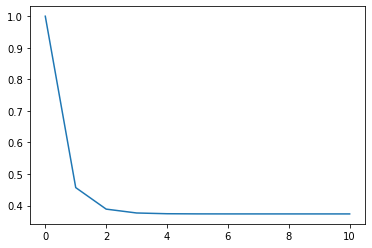

In [39]:
plt.plot(tauEM)

## VBEM

**Question 2** : mettre en oeuvre VBEM, et donner les paramètres des lois marginales approximatives de $\tau$ et $x$.

In [40]:
def VBEM(y, A, sigma_n, alpha, beta, niter):
    
    alphapost = alpha;
    betapost = beta;
    N = A.shape[1]
       
    
    for n in range(niter):
        # itération sur x
        taumean = alphapost/betapost;
        Rpost = np.linalg.inv(A.T @ A / sigma_n + taumean * np.eye(A.shape[1]))
        Xpost = Rpost @ A.T @ y / sigma_n
        
        # itération sur tau
        
        alphapost = alpha + N/2
        betapost = beta + (np.sum(Xpost**2) + np.trace(Rpost))/2
        
    return alphapost, betapost, Xpost, Rpost

In [51]:
alphapost, betapost, Xpost, Rpost = VBEM(y, A, sigma_n, alpha, beta, 100);

In [52]:
alphapost

18.0

In [53]:
betapost

44.893083027127346

In [ ]:
# tau a posteriori
alphapost/betapost

**Question 3** : sur un même graphique, tracer l'histogramme des échantillons de $\tau$ obtenus par l'échantillonneur de Gibbs, la valeur $\tau$ obtenue par EM, et la distribution a posteriori de $\tau$ donnée par VBEM.

In [57]:
#vrai tau
tau

0.3037709286328073

In [58]:
# tau EM
tauEM[-1]

0.373373067579267

In [59]:
# moyenne et cov. a posteriori pour EM
REM = np.linalg.inv(A.T @ A / sigma_n + tauEM[-1] * np.eye(A.shape[1]))
XEM = REM @ A.T @ y / sigma_n
        

In [60]:
#erreur EM
np.sum((XEM-x)**2)

10.535316833718367

In [61]:
#erreur VBEM
np.sum((Xpost-x)**2)

10.636208816931617

In [63]:
#erreur max. de vraisemblance
np.sum((np.linalg.inv(A)@y-x)**2)

49885.82422121226

In [64]:
XS, TS = gibbs(y, A, alpha, beta, sigma_n, np.zeros([N]), 1, 0.1, 1000)

In [65]:
# EAP Gibbs
Xgibbs = np.mean(XS, 1)

In [66]:
# erreur Gibbs
np.sum((Xgibbs-x)**2)

10.273134092550192

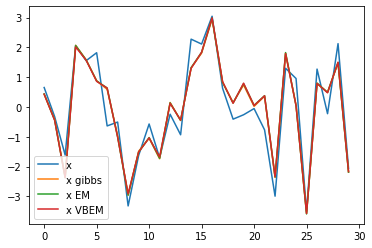

In [78]:
plt.plot(x, label="x")
plt.plot(Xgibbs, label="x gibbs")
plt.plot(XEM, label="x EM")
plt.plot(Xpost, label="x VBEM")
plt.legend()